In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
import nltk
import re 
import sys
from textblob import Word, TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential

In [2]:
train_df = pd.read_csv("twitter_training.csv", sep=',',
                       names=['Tweet_ID','Entity','Sentiment','Tweet_content'])


In [3]:
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
train_df.columns

Index(['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_content'], dtype='object')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
train_shape= train_df.shape
print("train data shape:",train_shape)

train data shape: (74682, 4)


In [7]:
train_df.isna().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64

In [8]:
train_df.dropna(axis=0, inplace=True)

In [9]:
train_df.isna().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64

In [10]:
train_df.duplicated().sum()

2340

In [11]:
train_df.drop_duplicates(inplace=True)

In [12]:
train_df.duplicated().sum()

0

In [13]:
train_df['Entity'].value_counts()

TomClancysRainbowSix                 2328
Verizon                              2319
MaddenNFL                            2315
CallOfDuty                           2314
Microsoft                            2304
WorldOfCraft                         2300
NBA2K                                2299
LeagueOfLegends                      2296
TomClancysGhostRecon                 2291
Facebook                             2289
ApexLegends                          2278
johnson&johnson                      2257
Battlefield                          2255
Amazon                               2249
CallOfDutyBlackopsColdWar            2242
FIFA                                 2238
Dota2                                2225
Overwatch                            2220
Hearthstone                          2219
HomeDepot                            2216
GrandTheftAuto(GTA)                  2208
Borderlands                          2206
Xbox(Xseries)                        2201
Google                            

In [14]:
train_df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [15]:
sentiment_groups = train_df.groupby(by="Sentiment")
len(sentiment_groups)


4

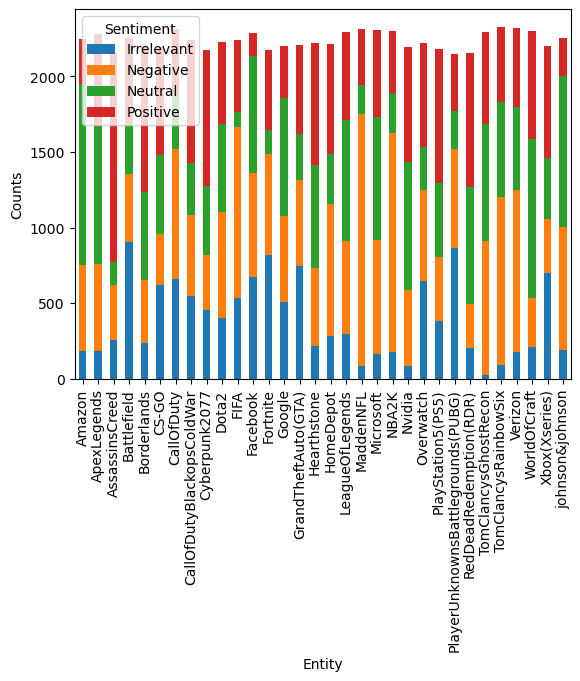

In [16]:

grouped = train_df.groupby(['Entity', 'Sentiment']).size().reset_index(name='counts')
pivot = grouped.pivot(index='Entity', columns='Sentiment', values='counts')
pivot.plot(kind='bar', stacked=True)
plt.xlabel('Entity')
plt.ylabel('Counts')
plt.show()


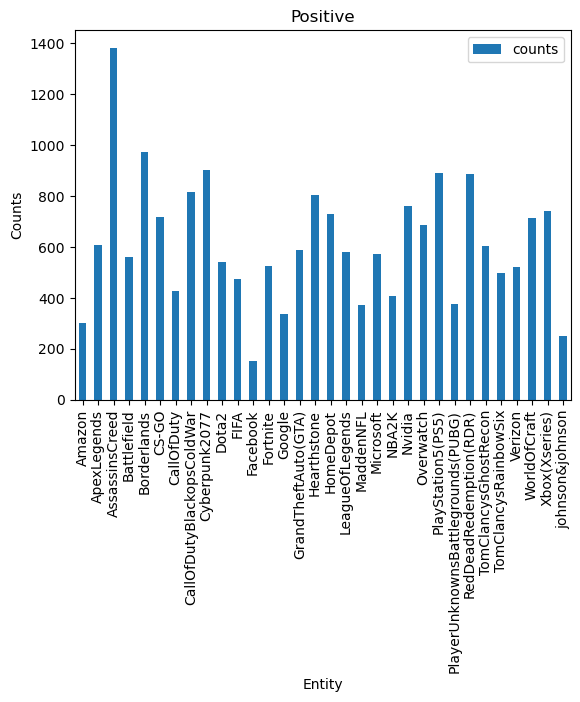

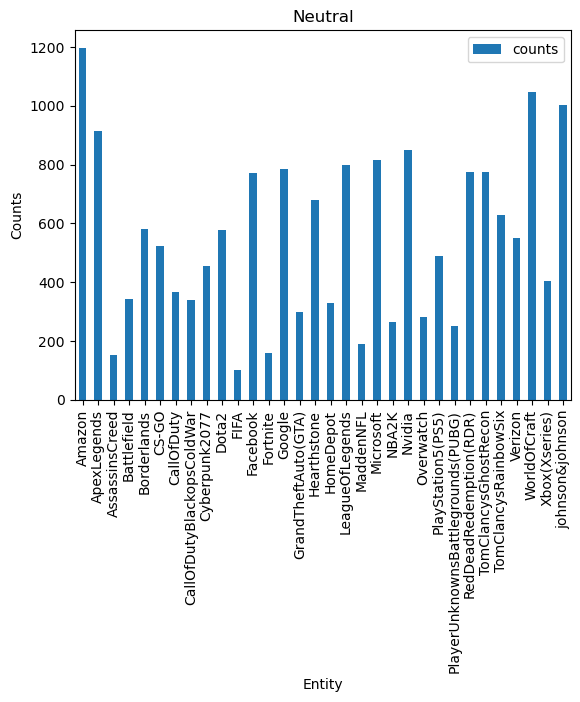

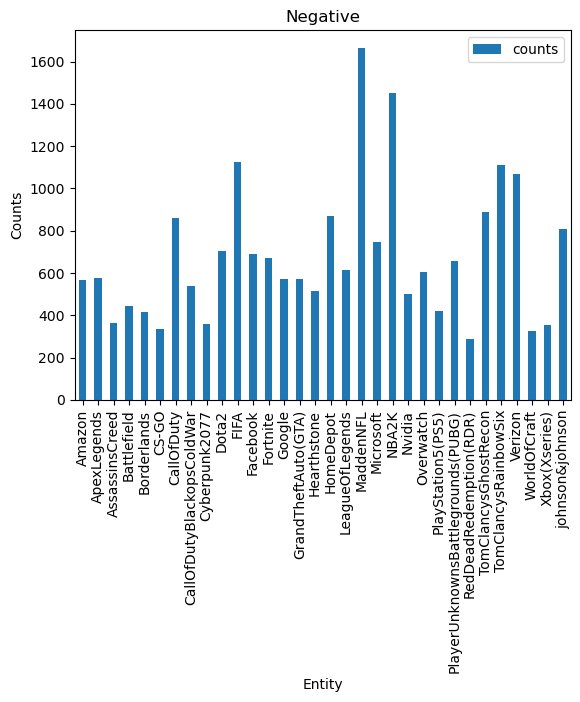

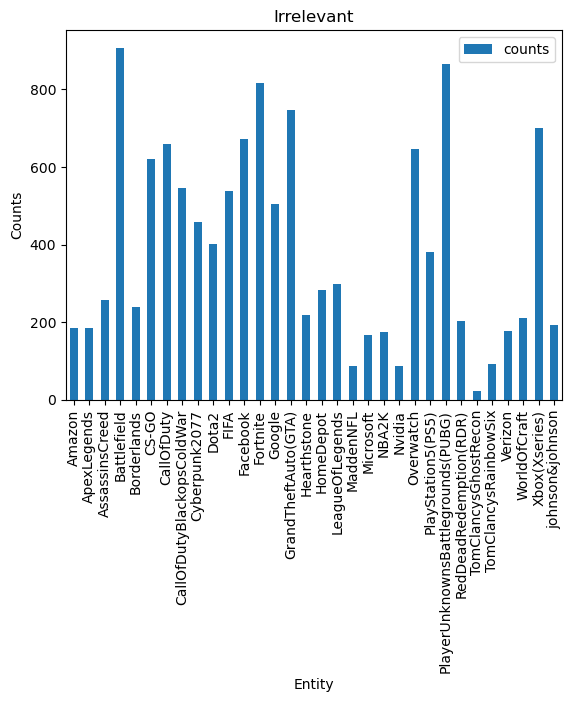

In [17]:
sentiments = ['Positive', 'Neutral', 'Negative', 'Irrelevant']

for sentiment in sentiments:
    subset = train_df[train_df['Sentiment'] == sentiment]
    counts = subset.groupby('Entity').size().reset_index(name='counts')
    if counts.empty:
        print(f"No instances of {sentiment} in the data.")
    else:
        counts.plot(kind='bar', x='Entity', y='counts')
        plt.xlabel('Entity')
        plt.ylabel('Counts')
        plt.title(sentiment)
        plt.show()


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

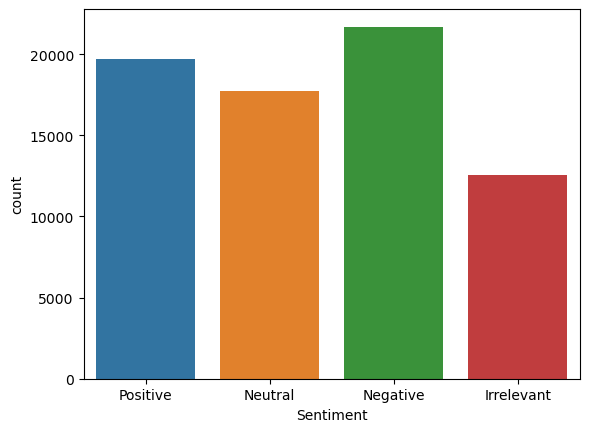

In [18]:
sns.countplot(x=train_df['Sentiment'])

In [19]:
data_info=train_df.groupby(['Entity', 'Sentiment']).Sentiment.count().unstack()
data_info

Sentiment,Irrelevant,Negative,Neutral,Positive
Entity,,,,
Amazon,185,565,1197,302
ApexLegends,185,574,913,606
AssassinsCreed,256,365,153,1382
Battlefield,907,445,342,561
Borderlands,238,415,581,972
CS-GO,620,335,523,717
CallOfDuty,660,861,367,426
CallOfDutyBlackopsColdWar,545,540,340,817
Cyberpunk2077,457,360,456,902


In [20]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\belal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\belal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
def preprocess_tweets(tweet):
    preprocessed_tweet = tweet
    preprocessed_tweet.replace('[^\w\s]',' ')
    preprocessed_tweet = ' '.join(word for word in preprocessed_tweet.split() if word not in stop_words)
    preprocessed_tweet = ' '.join(word for word in preprocessed_tweet.split() if word not in stemmer.stem(word))
    preprocessed_tweet = ' '.join(Word(word).lemmatize() for word in preprocessed_tweet.split()) 
    return(preprocessed_tweet) 

In [22]:
train_df['Tweet_content']=train_df['Tweet_content'].apply(lambda x: preprocess_tweets(x))
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,getting borderland
1,2401,Borderlands,Positive,I coming border I
2,2401,Borderlands,Positive,getting borderland
3,2401,Borderlands,Positive,coming borderland
4,2401,Borderlands,Positive,getting borderland


In [23]:
le = preprocessing.LabelEncoder()
train_df['Sentiment']=le.fit_transform(train_df['Sentiment'])

In [24]:
X = train_df['Tweet_content']
Y= train_df['Sentiment']

In [25]:
X.shape

(71656,)

In [26]:
Y.shape

(71656,)

In [27]:

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X)
X= tfidf_vectorizer.transform(X)
tfidf_vectorizer.get_feature_names_out()

array(['00', '00011', '00014', ..., 'это', 'яй', 'ясс'], dtype=object)

In [28]:
x_train , x_test , y_train , y_test = train_test_split(X,Y,test_size = .25 , random_state=2)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [30]:
text_classifier = RandomForestClassifier(n_estimators=50, random_state=0)

In [31]:
text_classifier.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [32]:
y_pred=text_classifier.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      3003
           1       0.86      0.86      0.86      5498
           2       0.89      0.82      0.85      4507
           3       0.76      0.88      0.81      4906

    accuracy                           0.84     17914
   macro avg       0.85      0.83      0.84     17914
weighted avg       0.85      0.84      0.84     17914



In [33]:
text_classifier.score(x_train,y_train)

0.9456105094711771

In [34]:
test_data_accuracy = accuracy_score(y_pred,y_test)
test_data_accuracy

0.8415764206765658

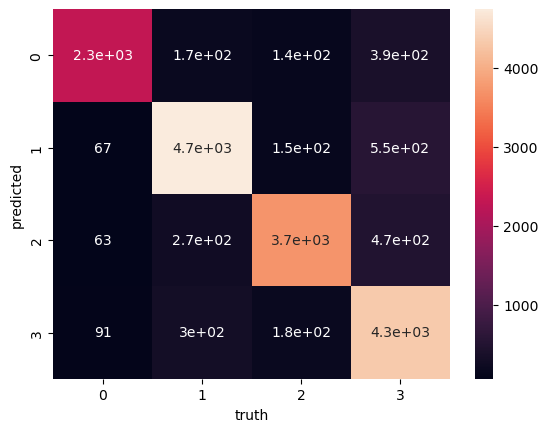

In [35]:
matrix = confusion_matrix(y_test , y_pred)
sns.heatmap(matrix , annot =True)
plt.xlabel('truth')
plt.ylabel('predicted')
plt.show()
     